In [15]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
random.seed(123)
np.random.seed(123)

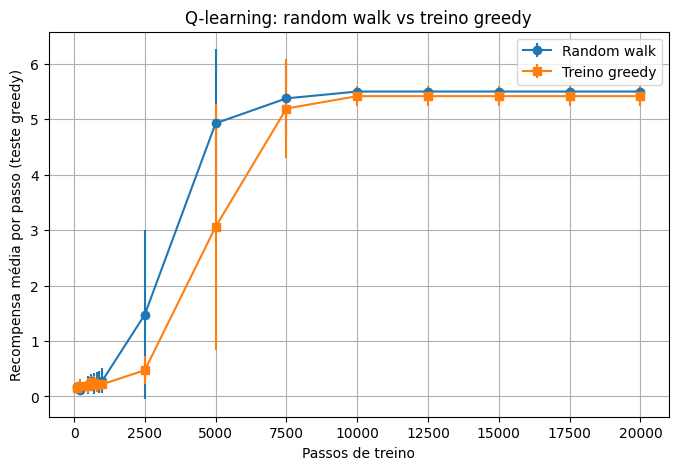

C:\Users\nicol\AppData\Local\Temp\ipykernel_33160\1289837942.py:219: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_times_random, train_times_greedy],


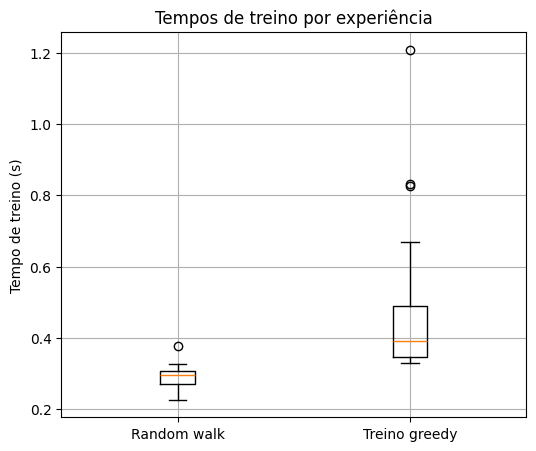

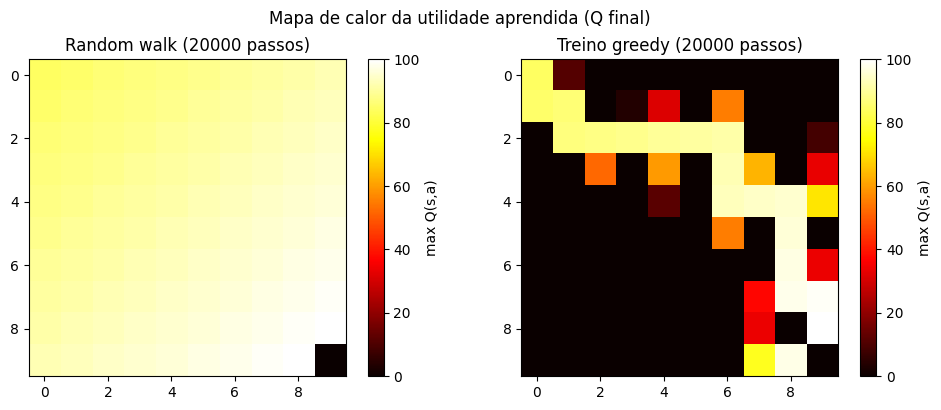

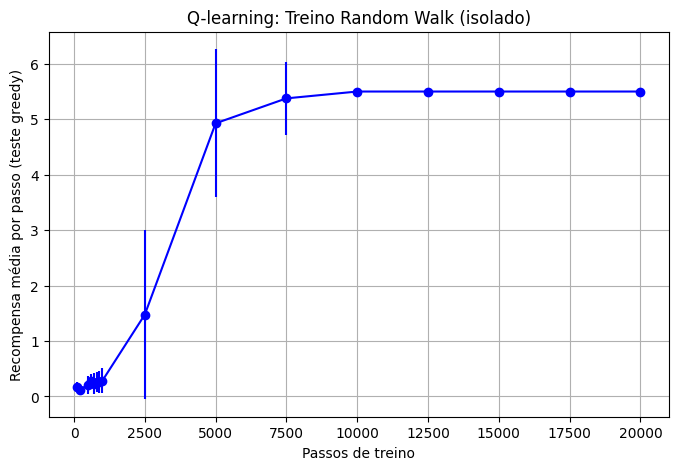

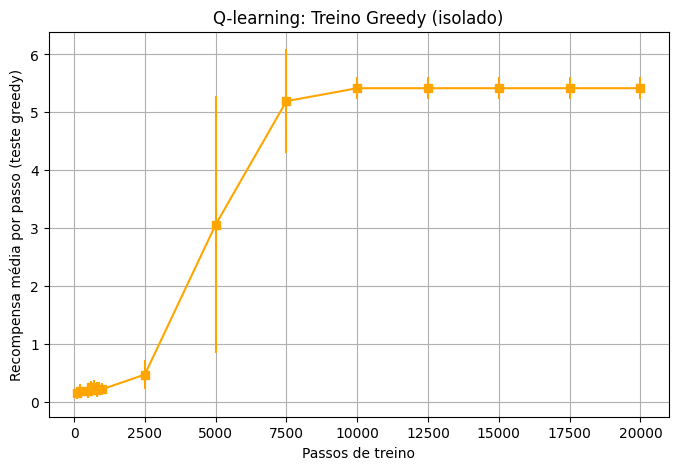

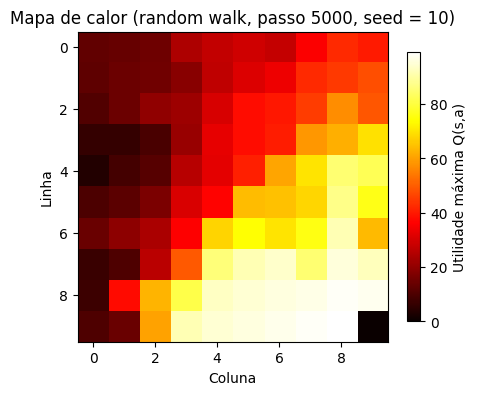

In [3]:

#  Definição do ambiente com base no ex1
GRID_ROWS = 10
GRID_COLS = 10
START_STATE = 1
GOAL_STATE = 100

ACTIONS = ["up", "down", "left", "right"]
ACTION_DELTAS = {
    "up":    (-1, 0),
    "down":  (1, 0),
    "left":  (0, -1),
    "right": (0, 1),
}

def state_to_coords(state):
    row = (state - 1) // GRID_COLS
    col = (state - 1) % GRID_COLS
    return row, col

def coords_to_state(row, col):
    return row * GRID_COLS + col + 1

def transition(state, action):
    row, col = state_to_coords(state)
    dr, dc = ACTION_DELTAS[action]
    new_row = row + dr
    new_col = col + dc

    # fora da grelha fica no mesmo sítio
    if not (0 <= new_row < GRID_ROWS and 0 <= new_col < GRID_COLS):
        return state

    return coords_to_state(new_row, new_col)

def reward(state):
    # só o objetivo tem recompensa
    return 100 if state == GOAL_STATE else 0

def environment_step(state, action):
    
    next_state = transition(state, action)
    r = reward(next_state)
    done = (next_state == GOAL_STATE)
    return next_state, r, done



#  Q-learning


N_STATES = GRID_ROWS * GRID_COLS
N_ACTIONS = len(ACTIONS)
ACTION_INDEX = {a: i for i, a in enumerate(ACTIONS)}

ALPHA = 0.7
GAMMA = 0.99

def create_q_table():
    return np.zeros((N_STATES, N_ACTIONS), dtype=float)

def random_action():
    return random.choice(ACTIONS)

def greedy_action(Q, state):
    # Escolhe a melhor ação para o estado dado (desempate aleatório)
    s_idx = state - 1
    q_vals = Q[s_idx, :]
    max_q = np.max(q_vals)
    best = np.where(q_vals == max_q)[0]
    a_idx = random.choice(best)
    return ACTIONS[a_idx]

def q_learning_update(Q, state, action, next_state, r, done):
 
    # Atualiza Q(s,a). Se o próximo estado for terminal, não usa valor futuro, evitando que o reset dê valor ao estado 1.
   
    s_idx = state - 1
    a_idx = ACTION_INDEX[action]

    if done:
        target = r
    else:
        s_next_idx = next_state - 1
        max_q_next = np.max(Q[s_next_idx, :])
        target = r + GAMMA * max_q_next

    current_q = Q[s_idx, a_idx]
    Q[s_idx, a_idx] = (1 - ALPHA) * current_q + ALPHA * target

def run_greedy_test(Q, num_steps=1000):
    """
    Teste: durante num_steps segue sempre a melhor ação segundo Q.
    Q não é alterada.
    """
    state = START_STATE
    total_reward = 0

    t0 = time.time()
    for _ in range(num_steps):
        action = greedy_action(Q, state)
        next_state, r, done = environment_step(state, action)
        total_reward += r

        if done:
            state = START_STATE   # recomeça episódio
        else:
            state = next_state
    t1 = time.time()

    mean_reward = total_reward / num_steps
    exec_time = t1 - t0
    return mean_reward, exec_time



#  Ciclos de treino


MAX_STEPS_PER_EPISODE = 1000
TRAINING_STEPS = 20000
N_EXPERIMENTS = 30

CHECKPOINTS = [100, 200, 500, 600, 700, 800, 900, 1000,
               2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

def train_q_learning(policy_mode="random"):
    
    rewards_at_checkpoints = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
    test_times_at_checkpoints = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
    train_times = np.zeros(N_EXPERIMENTS)
    Q_final = None
    Q_heatmap_5000 = None  # para guardar Q no passo 5000 

    for exp in range(N_EXPERIMENTS):
        Q = create_q_table()
        state = START_STATE
        steps_in_episode = 0
        checkpoint_idx = 0

        t0 = time.time()
        for step in range(1, TRAINING_STEPS + 1):

            # política de treino
            if policy_mode == "random":
                action = random_action()
            elif policy_mode == "greedy":
                action = greedy_action(Q, state)
            else:
                raise ValueError("politica nao existe")

            next_state, r, done = environment_step(state, action)
            q_learning_update(Q, state, action, next_state, r, done)

            steps_in_episode += 1
            if done or steps_in_episode >= MAX_STEPS_PER_EPISODE:
                # termina episódio, volta ao início sem update extra
                state = START_STATE
                steps_in_episode = 0
            else:
                state = next_state

            # guardar Q no passo 5000 
            if policy_mode == "random" and exp == 0 and step == 5000:
                Q_heatmap_5000 = Q.copy()

            # testes nos checkpoints
            if checkpoint_idx < len(CHECKPOINTS) and step == CHECKPOINTS[checkpoint_idx]:
                mean_r, t_test = run_greedy_test(Q, num_steps=1000)
                rewards_at_checkpoints[exp, checkpoint_idx] = mean_r
                test_times_at_checkpoints[exp, checkpoint_idx] = t_test
                checkpoint_idx += 1

        t1 = time.time()
        train_times[exp] = t1 - t0

        if exp == N_EXPERIMENTS - 1:
            Q_final = Q.copy()

    return rewards_at_checkpoints, test_times_at_checkpoints, train_times, Q_final, Q_heatmap_5000



#  Executar experiências

random.seed(10)   # seed indicada no enunciado para a figura
np.random.seed(10)

# 2.a – random walk
rewards_random, test_times_random, train_times_random, Q_random, Q_5000 = train_q_learning("random")

# 2.b – treino greedy
rewards_greedy, test_times_greedy, train_times_greedy, Q_greedy, _ = train_q_learning("greedy")



#  Gráficos de comparação

# recompensas médias em cada checkpoint
mean_rewards_random = rewards_random.mean(axis=0)
std_rewards_random  = rewards_random.std(axis=0)

mean_rewards_greedy = rewards_greedy.mean(axis=0)
std_rewards_greedy  = rewards_greedy.std(axis=0)

plt.figure(figsize=(8, 5))
plt.errorbar(CHECKPOINTS, mean_rewards_random, yerr=std_rewards_random,
             fmt='-o', label="Random walk")
plt.errorbar(CHECKPOINTS, mean_rewards_greedy, yerr=std_rewards_greedy,
             fmt='-s', label="Treino greedy")
plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média por passo (teste greedy)")
plt.title("Q-learning: random walk vs treino greedy")
plt.grid(True)
plt.legend()
plt.show()

# tempos de treino (20000 passos)
plt.figure(figsize=(6, 5))
plt.boxplot([train_times_random, train_times_greedy],
            labels=["Random walk", "Treino greedy"])
plt.ylabel("Tempo de treino (s)")
plt.title("Tempos de treino por experiência")
plt.grid(True)
plt.show()

# heatmaps finais 
max_q_random_final = Q_random.max(axis=1).reshape((GRID_ROWS, GRID_COLS))
max_q_greedy_final = Q_greedy.max(axis=1).reshape((GRID_ROWS, GRID_COLS))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(max_q_random_final, origin="upper", cmap="hot", vmin=0, vmax=100)
plt.title("Random walk (20000 passos)")
plt.colorbar(label="max Q(s,a)")

plt.subplot(1, 2, 2)
plt.imshow(max_q_greedy_final, origin="upper", cmap="hot", vmin=0, vmax=100)
plt.title("Treino greedy (20000 passos)")
plt.colorbar(label="max Q(s,a)")

plt.suptitle("Mapa de calor da utilidade aprendida (Q final)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.errorbar(CHECKPOINTS, mean_rewards_random, yerr=std_rewards_random,
             fmt='-o', color="blue")
plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média por passo (teste greedy)")
plt.title("Q-learning: Treino Random Walk (isolado)")
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))
plt.errorbar(CHECKPOINTS, mean_rewards_greedy, yerr=std_rewards_greedy,
             fmt='-s', color="orange")
plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média por passo (teste greedy)")
plt.title("Q-learning: Treino Greedy (isolado)")
plt.grid(True)
plt.show()



#  Heatmap no ponto 5000 para comparar com o enunciado



max_q_5000 = Q_5000.max(axis=1)
heatmap_5000 = max_q_5000.reshape((GRID_ROWS, GRID_COLS))

plt.figure(figsize=(5, 5))
plt.imshow(heatmap_5000, origin="upper", cmap="hot", vmin=0, vmax=heatmap_5000.max())
plt.colorbar(label="Utilidade máxima Q(s,a)", shrink=0.7)
plt.title("Mapa de calor (random walk, passo 5000, seed = 10)")
plt.xlabel("Coluna")
plt.ylabel("Linha")
plt.show()



Nos testes realizados, verificou-se que o Q-learning aprende progressivamente a aproximar-se do objetivo, independentemente da política de treino utilizada. O método random walk apresenta tempos de execução ligeiramente menores, pois selecionar ações aleatórias é computacionalmente mais simples do que procurar sempre a melhor ação na tabela Q.
O treino greedy aprende mais rápido nos primeiros milhares de passos, mas explora menos o ambiente e pode demorar mais a descobrir caminhos alternativos.

Ambos os métodos convergem para uma recompensa média de aproximadamente 5.5 que seria o melhor valor medio possivel por passo já que 1000/55(nº de vezes que o robot chega ao objetivo))~= 5.

Os HeatMap mostram também que o random tende a preencher a grelha de forma mais uniforme devido à maior exploração, enquanto o treino greedy reforça apenas os estados que realmente visita.

### Ex 3

Treino ε-greedy com greed fixo = 0.2
Treino ε-greedy com greed fixo = 0.5
Treino ε-greedy com greed fixo = 0.9

Treino ε-greedy com greed progressivo (0.3 → 1.0)


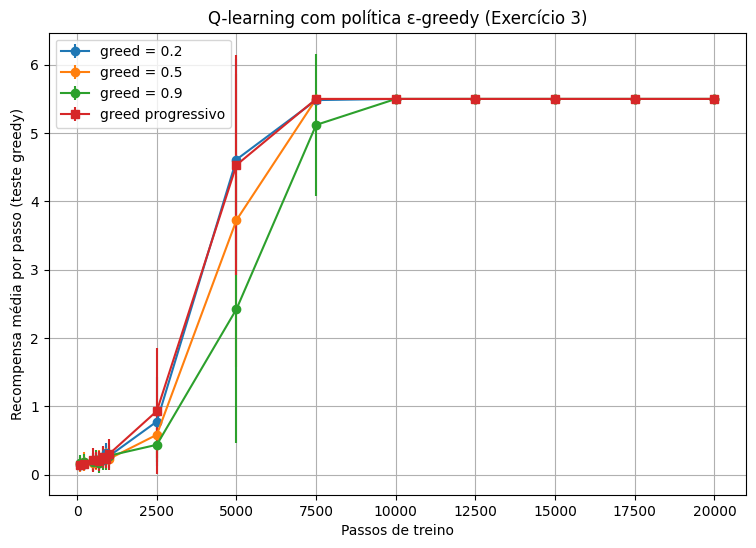

C:\Users\nicol\AppData\Local\Temp\ipykernel_33160\3065583465.py:189: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_train_times, labels=labels)


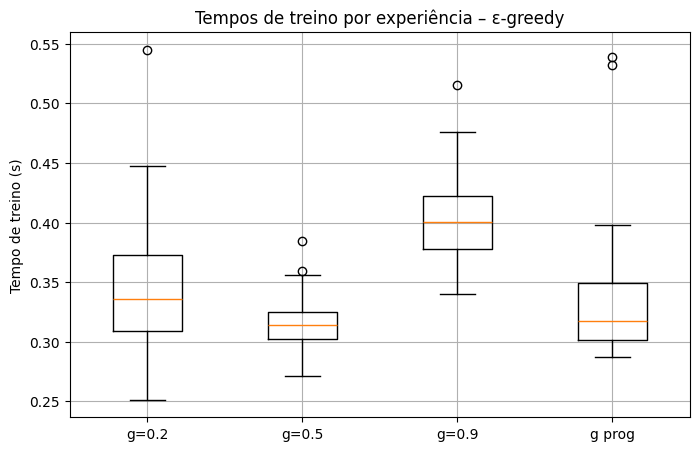

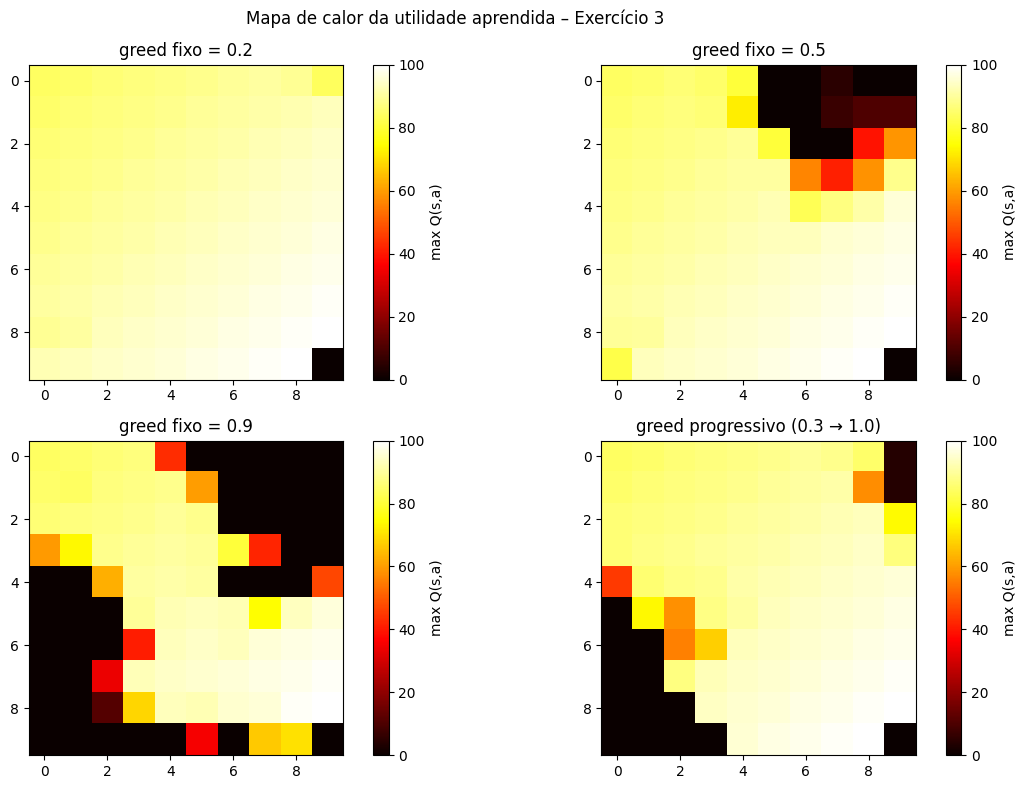

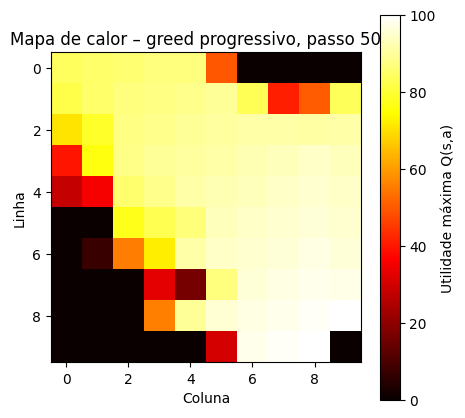

In [4]:
def epsilon_greedy_action(Q, state, greed):
    # sorteio um número entre 0 e 1
    if random.random() < greed:

        return greedy_action(Q, state)
    else:
        
        return random_action()



# Treino Q-learning com ε-greedy de greed FIXO   (0.2, 0.5, 0.9)

def train_q_learning_epsilon_greedy_fix(greed_value): #greed_value = probabilidade de agir de forma greedy.
    
    rewards_at_checkpoints = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
    test_times_at_checkpoints = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
    train_times = np.zeros(N_EXPERIMENTS)
    Q_final = None

    for exp in range(N_EXPERIMENTS):
        Q = create_q_table()
        state = START_STATE
        steps_in_episode = 0
        checkpoint_idx = 0

        t0 = time.time()
        for step in range(1, TRAINING_STEPS + 1):

            
            action = epsilon_greedy_action(Q, state, greed_value)

            next_state, r, done = environment_step(state, action)
            q_learning_update(Q, state, action, next_state, r, done)

            steps_in_episode += 1

            # se chegou ao objetivo ou já fez 1000 passos, recomeça no estado 1
            if done or steps_in_episode >= MAX_STEPS_PER_EPISODE:
                state = START_STATE
                steps_in_episode = 0
            else:
                state = next_state

            # quando atingimos um checkpoint, corremos um teste greedy
            if checkpoint_idx < len(CHECKPOINTS) and step == CHECKPOINTS[checkpoint_idx]:
                mean_r, t_test = run_greedy_test(Q)
                rewards_at_checkpoints[exp, checkpoint_idx] = mean_r
                test_times_at_checkpoints[exp, checkpoint_idx] = t_test
                checkpoint_idx += 1

        t1 = time.time()
        train_times[exp] = t1 - t0

        # Q final da última experiência para o mapa de calor
        if exp == N_EXPERIMENTS - 1:
            Q_final = Q.copy()

    return rewards_at_checkpoints, test_times_at_checkpoints, train_times, Q_final



# Treino Q-learning com ε-greedy PROGRESSIVO (greed 0.3 → 1.0)
#   - primeiros 30% dos passos com greed = 0.3
#   - depois aumenta linearmente até 1.0 no final dos 20000 passos

def train_q_learning_epsilon_greedy_progressive():

    rewards_at_checkpoints = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
    test_times_at_checkpoints = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
    train_times = np.zeros(N_EXPERIMENTS)
    Q_final = None
    Q_heatmap_5000 = None

    # número de passos que corresponde a 30% do treino
    limit_30 = int(0.3 * TRAINING_STEPS)

    for exp in range(N_EXPERIMENTS):
        Q = create_q_table()
        state = START_STATE
        steps_in_episode = 0
        checkpoint_idx = 0

        t0 = time.time()
        for step in range(1, TRAINING_STEPS + 1):

            # cálculo do greed progressivo
            if step <= limit_30:
                greed = 0.3
            else:
                # daqui até ao fim, o greed sobe de 0.3 até 1.0 de forma linear
                frac = (step - limit_30) / (TRAINING_STEPS - limit_30)
                greed = 0.3 + 0.7 * frac   # no fim dá 1.0

            action = epsilon_greedy_action(Q, state, greed)

            next_state, r, done = environment_step(state, action)
            q_learning_update(Q, state, action, next_state, r, done)

            steps_in_episode += 1

            if done or steps_in_episode >= MAX_STEPS_PER_EPISODE:
                state = START_STATE
                steps_in_episode = 0
            else:
                state = next_state

            # guardar Q no passo 5000 da primeira experiência (para o heatmap)
            if exp == 0 and step == 5000:
                Q_heatmap_5000 = Q.copy()

            if checkpoint_idx < len(CHECKPOINTS) and step == CHECKPOINTS[checkpoint_idx]:
                mean_r, t_test = run_greedy_test(Q)
                rewards_at_checkpoints[exp, checkpoint_idx] = mean_r
                test_times_at_checkpoints[exp, checkpoint_idx] = t_test
                checkpoint_idx += 1

        t1 = time.time()
        train_times[exp] = t1 - t0

        if exp == N_EXPERIMENTS - 1:
            Q_final = Q.copy()

    return rewards_at_checkpoints, test_times_at_checkpoints, train_times, Q_final, Q_heatmap_5000


# Correr os quatro cenários de ε-greedy

random.seed(10)
np.random.seed(10)

# Cenários de greed fixo
GREEDS = [0.2, 0.5, 0.9]

results_fix = {}
for g in GREEDS:
    print(f"Treino ε-greedy com greed fixo = {g}")
    rewards, test_times, train_times, Q_final = train_q_learning_epsilon_greedy_fix(g)
    results_fix[g] = {
        "rewards": rewards,
        "test_times": test_times,
        "train_times": train_times,
        "Q_final": Q_final,
    }

print("\nTreino ε-greedy com greed progressivo (0.3 → 1.0)")
rewards_prog, test_times_prog, train_times_prog, Q_final_prog, Q_5000_prog = \
    train_q_learning_epsilon_greedy_progressive()

# guardar num dicionário para ser mais fácil usar nos gráficos
results_prog = {
    "rewards": rewards_prog,
    "test_times": test_times_prog,
    "train_times": train_times_prog,
    "Q_final": Q_final_prog,
    "Q_5000": Q_5000_prog,
}


#Gráfico da recompensa média (ε-greedy)
plt.figure(figsize=(9, 6))

# cada curva é a média das 30 experiências
for g in GREEDS:
    mean_r = results_fix[g]["rewards"].mean(axis=0)
    std_r  = results_fix[g]["rewards"].std(axis=0)
    plt.errorbar(CHECKPOINTS, mean_r, yerr=std_r, fmt='-o', label=f"greed = {g}")

# curva do greed progressivo
mean_r_prog = results_prog["rewards"].mean(axis=0)
std_r_prog  = results_prog["rewards"].std(axis=0)
plt.errorbar(CHECKPOINTS, mean_r_prog, yerr=std_r_prog, fmt='-s', label="greed progressivo")

plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média por passo (teste greedy)")
plt.title("Q-learning com política ε-greedy (Exercício 3)")
plt.grid(True)
plt.legend()
plt.show()


# Tempos de treino para cada estratégia ε-greedy


labels = [f"g={g}" for g in GREEDS] + ["g prog"]
all_train_times = [results_fix[g]["train_times"] for g in GREEDS] + [results_prog["train_times"]]

plt.figure(figsize=(8, 5))
plt.boxplot(all_train_times, labels=labels)
plt.ylabel("Tempo de treino (s)")
plt.title("Tempos de treino por experiência – ε-greedy")
plt.grid(True)
plt.show()



#Mapas de calor da Q final

# %%
plt.figure(figsize=(12, 8))

# um subplot por cada greed fixo
for i, g in enumerate(GREEDS):
    Q_final = results_fix[g]["Q_final"]
    max_q = Q_final.max(axis=1).reshape((GRID_ROWS, GRID_COLS))

    plt.subplot(2, 2, i+1)
    plt.imshow(max_q, origin="upper", cmap="hot", vmin=0, vmax=100)
    plt.title(f"greed fixo = {g}")
    plt.colorbar(label="max Q(s,a)")

# último subplot para o greed progressivo
Q_final_prog = results_prog["Q_final"]
max_q_prog = Q_final_prog.max(axis=1).reshape((GRID_ROWS, GRID_COLS))

plt.subplot(2, 2, 4)
plt.imshow(max_q_prog, origin="upper", cmap="hot", vmin=0, vmax=100)
plt.title("greed progressivo (0.3 → 1.0)")
plt.colorbar(label="max Q(s,a)")

plt.suptitle("Mapa de calor da utilidade aprendida – Exercício 3")
plt.tight_layout()
plt.show()



# Heatmap no passo 5000 (greed progressivo)


max_q_5000_prog = results_prog["Q_5000"].max(axis=1).reshape((GRID_ROWS, GRID_COLS))

plt.figure(figsize=(5, 5))
plt.imshow(max_q_5000_prog, origin="upper", cmap="hot",
           vmin=0, vmax=max_q_5000_prog.max())
plt.colorbar(label="Utilidade máxima Q(s,a)")
plt.title("Mapa de calor – greed progressivo, passo 5000")
plt.xlabel("Coluna")
plt.ylabel("Linha")
plt.show()

Analisando os resultado é possivel verificar que com greed = 0.2, o agente escolhe ações aleatórias na maior parte do tempo, o que leva a muita exploração levando a que o heatmap fique quase todo suave e de baixo valor, mostrando que o agente raramente consolida trajetórias especificas.

Com greed = 0.9, acontece o oposto: o agente quase só segue a melhor ação atual. Aprende rapidamente um caminho para o objetivo, mas ignora quase toda a grelha. O heatmap mostra uma “faixa” muito quente e o resto praticamente a zero, ainda assim faz uma exploraçao maior do que no caso do exercicio 2. O greed=0.5 apresenta um comportamento intermedio

# Ex 4

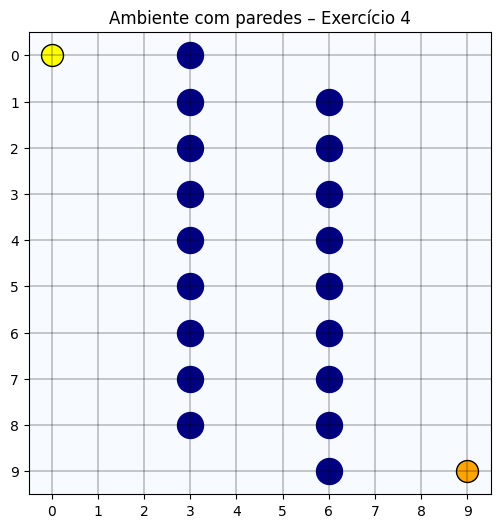

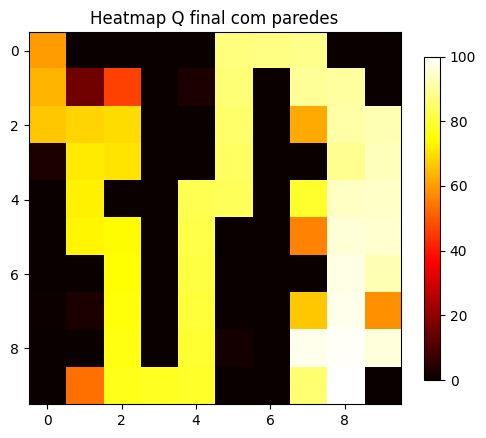

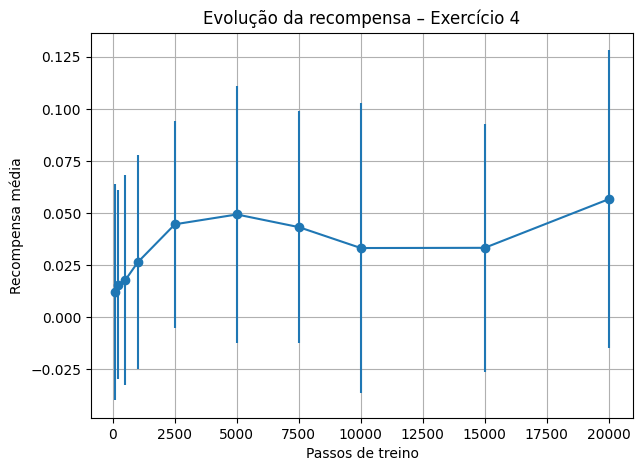

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random, time

# Grelha e estados principais
GRID_ROWS = 10
GRID_COLS = 10
START_STATE = 1
GOAL_STATE = 100

# Paredes do enunciado (versão A)
WALL_STATES_EX4 = set()
for r in range(0, 9):
    WALL_STATES_EX4.add((r, 3))
for r in range(1, 10):
    WALL_STATES_EX4.add((r, 6))

# Ações possíveis
ACTIONS = ["up", "down", "left", "right"]
ACTION_DELTAS = {
    "up": (-1, 0),
    "down": (1, 0),
    "left": (0, -1),
    "right": (0, 1)
}

# Conversões de estado
def state_to_coords(state):
    return (state - 1) // GRID_COLS, (state - 1) % GRID_COLS

def coords_to_state(r, c):
    return r * GRID_COLS + c + 1

# Movimento considerando paredes
def transition_with_walls(state, action):
    r, c = state_to_coords(state)
    dr, dc = ACTION_DELTAS[action]
    nr = r + dr
    nc = c + dc

    if not (0 <= nr < GRID_ROWS and 0 <= nc < GRID_COLS):
        return state, True
    if (nr, nc) in WALL_STATES_EX4:
        return state, True

    return coords_to_state(nr, nc), False

# Ambiente com penalização
def environment_step_walls(state, action):
    next_state, wall = transition_with_walls(state, action)
    if next_state == GOAL_STATE:
        return next_state, 100, True
    if wall:
        return state, -0.1, False
    return next_state, 0, False

# Tabela Q
def create_q_table():
    return np.zeros((100, 4))

ALPHA = 0.7
GAMMA = 0.99

# Escolha greedy
def greedy_action(Q, state):
    s = state - 1
    row = Q[s]
    best = np.where(row == row.max())[0]
    return ACTIONS[random.choice(best)]

# ε-greedy
def epsilon_greedy_action(Q, state, greed):
    if random.random() < greed:
        return greedy_action(Q, state)
    return random.choice(ACTIONS)

# Atualização Q-learning
def q_learning_update(Q, state, action, next_state, r, done):
    s = state - 1
    a = ACTIONS.index(action)
    if done:
        target = r
    else:
        target = r + GAMMA * Q[next_state - 1].max()
    Q[s, a] = (1 - ALPHA) * Q[s, a] + ALPHA * target

# Teste greedy
def run_greedy_test(Q, steps=1000):
    state = START_STATE
    total = 0
    for _ in range(steps):
        action = greedy_action(Q, state)
        next_state, r, done = environment_step_walls(state, action)
        total += r
        state = START_STATE if done else next_state
    return total / steps

# Treino com greed progressivo
TRAINING_STEPS = 50000
MAX_STEPS_PER_EPISODE = 1000
CHECKPOINTS = [100,200,500,1000,2500,5000,7500,10000,15000,20000]
N_EXPERIMENTS = 30

def train_q_learning_walls_progressive():
    rewards = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
    Q_final = None
    lim30 = int(0.3 * TRAINING_STEPS)

    for exp in range(N_EXPERIMENTS):
        Q = create_q_table()
        state = START_STATE
        steps_ep = 0
        chk = 0

        for step in range(1, TRAINING_STEPS + 1):
            if step <= lim30:
                greed = 0.3
            else:
                frac = (step - lim30) / (TRAINING_STEPS - lim30)
                greed = 0.3 + 0.7 * frac

            action = epsilon_greedy_action(Q, state, greed)
            next_state, r, done = environment_step_walls(state, action)
            q_learning_update(Q, state, action, next_state, r, done)

            if done or steps_ep >= MAX_STEPS_PER_EPISODE:
                state = START_STATE
                steps_ep = 0
            else:
                state = next_state
                steps_ep += 1

            if chk < len(CHECKPOINTS) and step == CHECKPOINTS[chk]:
                rewards[exp, chk] = run_greedy_test(Q)
                chk += 1

        if exp == N_EXPERIMENTS - 1:
            Q_final = Q.copy()

    return rewards, Q_final

# Desenho simples do ambiente
def draw_environment_ex4():
    grid = np.zeros((GRID_ROWS, GRID_COLS))
    plt.figure(figsize=(6,6))
    plt.imshow(grid, cmap="Blues", origin="upper")
    for (r, c) in WALL_STATES_EX4:
        plt.scatter(c, r, color="navy", s=350)
    plt.scatter(0,0,color="yellow",s=250,edgecolor="black")
    plt.scatter(9,9,color="orange",s=250,edgecolor="black")
    plt.xticks(range(GRID_COLS))
    plt.yticks(range(GRID_ROWS))
    plt.grid(color="black", linewidth=0.3)
    plt.title("Ambiente com paredes – Exercício 4")
    plt.show()

# Executar tudo
random.seed(10)
np.random.seed(10)

draw_environment_ex4()
rewards_walls, Q_walls_final = train_q_learning_walls_progressive()

# Heatmap final
max_q_final = Q_walls_final.max(axis=1).reshape((GRID_ROWS, GRID_COLS))
plt.figure(figsize=(6,6))
plt.imshow(max_q_final, origin="upper", cmap="hot", vmin=0, vmax=100)
plt.colorbar(shrink=0.7)
plt.title("Heatmap Q final com paredes")
plt.show()

# Gráfico da recompensa
mean_r = rewards_walls.mean(axis=0)
std_r = rewards_walls.std(axis=0)
plt.figure(figsize=(7,5))
plt.errorbar(CHECKPOINTS, mean_r, yerr=std_r, fmt="-o")
plt.grid(True)
plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média")
plt.title("Evolução da recompensa – Exercício 4")
plt.show()


# Ex 5 (Opcional)

Com probabilidade **95%**, o agente executa a ação pretendida (determinada pela política ou escolhida aleatoriamente no treino).

Com probabilidade **5%**, o agente **ignora a ação escolhida** e desloca-se para um **estado vizinho aleatório**, introduzindo assim não-determinismo no movimento.

In [25]:
#Definido nas alineas acima

N_EXPERIMENTS = 30
TRAINING_STEPS = 20000
SLIP_PROB = 0.05


# da-nos a lista de vizinhos do estado atual (todos os estados alcancaveis com uma ação válida, ignora movimentos que ficariam no mesmo sitio por sair da grelha)
def neighbor_states(state):
   
    neighbors = set()
    for a in ACTIONS:
        s_next = transition(state, a)
        if s_next != state:       # só conta se realmente se move
            neighbors.add(s_next)
    return list(neighbors)

def environment_step_nondeterministic(state, action, slip_prob= 0.05):
    if random.random() < slip_prob:
        # escolhe um vizinho aleatório do estado atual
        neighbors = neighbor_states(state)
        if len(neighbors) > 0:
            next_state = random.choice(neighbors)
        else:
            next_state = state  # canto isolado (não acontece nada)
    else:
        # comportamento normal, determinístico
        next_state = transition(state, action)

    r = reward(next_state)
    done = (next_state == GOAL_STATE)
    return next_state, r, done

#  greedy num ambiente não-deterministico (Q-table não é alterada durante o teste)
    
def run_greedy_test_nondeterministic(Q, num_steps=1000, slip_prob=0.05):
   
    state = START_STATE
    total_reward = 0

    for t in range(num_steps):
        action = greedy_action(Q, state)
        next_state, r, done = environment_step_nondeterministic(state, action, slip_prob=slip_prob)
        total_reward += r

        if done:
            state = START_STATE
        else:
            state = next_state

    return total_reward / num_steps

# Atualização Q-learning para o ambiente não-determinista, recebendo explicitamente a recompensa r.
def q_learning_update_nd(Q, state, action, next_state, r):

    s_idx = state - 1
    s_next_idx = next_state - 1
    a_idx = ACTION_INDEX[action]

    max_q_next = np.max(Q[s_next_idx, :])
    current_q = Q[s_idx, a_idx]
    target = r + GAMMA * max_q_next
    new_q = (1 - ALPHA) * current_q + ALPHA * target
    Q[s_idx, a_idx] = new_q

rewards_at_checkpoints_nd = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
execution_times_nd = np.zeros(N_EXPERIMENTS)
Q_final_nd = None

for exp in range(N_EXPERIMENTS):
    start_t = time.time()

    Q = create_q_table()
    state = START_STATE
    steps_in_episode = 0
    checkpoint_idx = 0

    for step in range(1, TRAINING_STEPS + 1):
        # treino com random walk (podemos trocar para greedy tbm )
        action = random_action()
        # action = greedy_action(Q, state) 

        # passo no ambiente não-determinista
        next_state, r, done = environment_step_nondeterministic(
            state, action, slip_prob=SLIP_PROB
        )

        # atualização Q-learning
        q_learning_update_nd(Q, state, action, next_state, r)

        # gestão de episódio
        steps_in_episode += 1
        if done or steps_in_episode >= MAX_STEPS_PER_EPISODE:
            state = START_STATE
            steps_in_episode = 0
        else:
            state = next_state

        # checkpoints (igual ao ex2)
        if checkpoint_idx < len(CHECKPOINTS) and step == CHECKPOINTS[checkpoint_idx]:
            mean_r = run_greedy_test_nondeterministic(
                Q, num_steps=1000, slip_prob=SLIP_PROB
            )
            rewards_at_checkpoints_nd[exp, checkpoint_idx] = mean_r
            checkpoint_idx += 1

    end_t = time.time()
    execution_times_nd[exp] = end_t - start_t

    if exp == N_EXPERIMENTS - 1:
        Q_final_nd = Q.copy()

# Heatmap final ambiente não-determinista com paredes do Ex.4
def plot_heatmap_nd_with_walls(Q_nd, title="Heatmap Q final – Exercício 5 (não-determinista)"):
    max_q = Q_nd.max(axis=1).reshape((GRID_ROWS, GRID_COLS))

    plt.figure(figsize=(6, 6))
    plt.imshow(max_q, origin="upper", cmap="hot", vmin=0, vmax=100)
    plt.colorbar(shrink=0.7)

    # paredes do Ex.4
    for (r, c) in WALL_STATES_EX4:
        plt.scatter(c, r, color="navy", s=350)

    # start e goal
    sr, sc = state_to_coords(START_STATE)
    gr, gc = state_to_coords(GOAL_STATE)
    plt.scatter(sc, sr, color="yellow", s=250, edgecolor="black")
    plt.scatter(gc, gr, color="orange", s=250, edgecolor="black")

    plt.xticks(range(GRID_COLS))
    plt.yticks(range(GRID_ROWS))
    plt.grid(color="black", linewidth=0.3)
    plt.title(title)
    plt.show()

    

# Plots

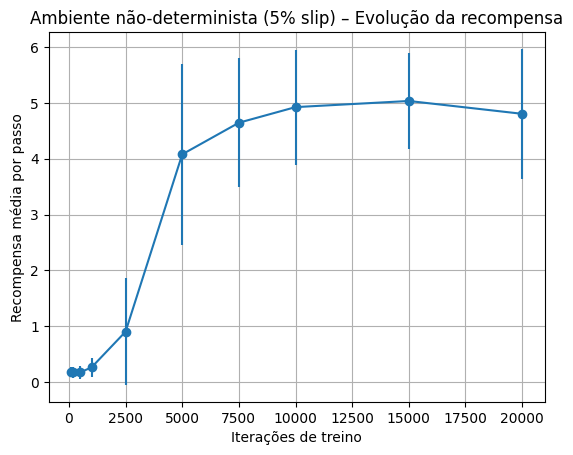

In [13]:
# Recompensa
mean_rewards_nd = rewards_at_checkpoints_nd.mean(axis=0)
std_rewards_nd = rewards_at_checkpoints_nd.std(axis=0)

plt.figure()
plt.errorbar(CHECKPOINTS, mean_rewards_nd, yerr=std_rewards_nd, fmt='-o')
plt.xlabel("Iterações de treino")
plt.ylabel("Recompensa média por passo")
plt.title("Ambiente não-determinista (5% slip) – Evolução da recompensa")
plt.grid(True)
plt.show()


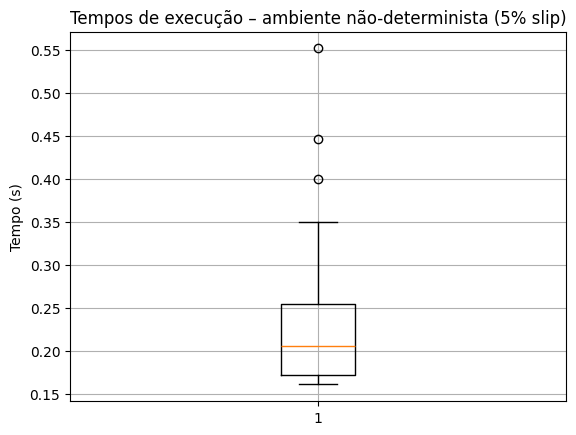

In [19]:
# Boxplots e tempos de execução
plt.figure()
plt.boxplot(execution_times_nd, vert=True)
plt.ylabel("Tempo (s)")
plt.title("Tempos de execução – ambiente não-determinista (5% slip)")
plt.grid(True)
plt.show()


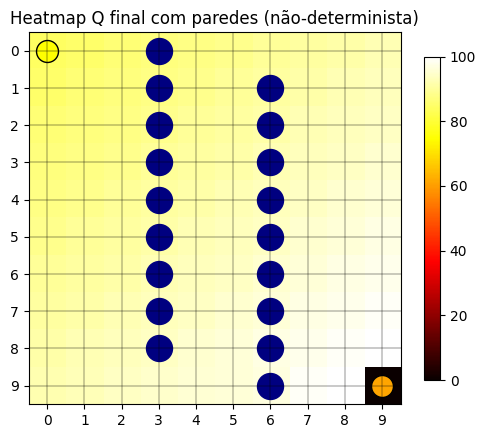

In [29]:

#plot do Heatmap com as paredes do ex4
plot_heatmap_nd_with_walls(Q_final_nd, "Heatmap Q final com paredes (não-determinista)")

## Impacto do Não-Determinismo nos Resultados 

Ao introduzir um comportamento **não-determinista** no ambiente, isto é, uma probabilidade de **5%** de o agente executar um movimento diferente do pretendido e deslocar-se para um dos estados vizinhos, os resultados do Q-learning foram afetados de várias formas visíveis. O comportamento não-determinismo introduz incerteza nas transições, o que torna a aprendizagem mais difícil e lenta. As recompensas são mais baixas, o desvio padrão é maior e a política aprendida torna-se menos precisa, embora mais adaptada a um ambiente com erros.  
